In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt
import alphalens as al
import pickle
import warnings
import json
from dateutil.relativedelta import relativedelta

from functions.alpha_evaluator import AlphaFactorEvaluator
from functions.alpha_generator import NoOverlapClassifier
from functions.data_processor import adjust_price_multiple
from functions.indicators import TechnicalIndicators, IndicatorExecutor

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
# define all parameters
BASE_PATH = './data/prices/all_thai_raw'
START_DATE = dt.date(2015, 1, 5)
LAST_DATE = None
ADD_CASH = False

start_year = START_DATE.year
if LAST_DATE:
    last_year = LAST_DATE.year
else:
    last_year = dt.date.today().year

<h1 style="color:turquoise">Load data from local</h1>

In [3]:
def extract_market_category(tag):
    if 'SET50' in tag:
        return 'SET50'
    elif 'SET100' in tag:
        return 'SET100'
    elif 'MAI' in tag:
        return 'MAI'
    return None

def extract_sector(tag):
    if isinstance(tag, list):
        tag_ = tag.copy()
        for market in ['SET50', 'SET100', 'MAI']:
            if market in tag_:
                tag_.remove(market)
        return tag_[0]
    return None


In [4]:
# scraped tags (from Siamchart)
tag_path = './content/thai/ticker_list/thai_ticker.json'
tag_df = pd.read_json(tag_path)
tag_df['market_category'] = tag_df['tag'].apply(extract_market_category)
tag_df['sector'] = tag_df['tag'].apply(extract_sector)

# drop duplicates
tag_df.drop_duplicates(subset=['ticker'], keep='last')
# assert tag_df.shape[0] == tag_df['ticker'].nunique()

tag_df.head()

,ticker,tag,market_category,sector
0,24CS,"[MAI, PROPCON-m, PROPCON-ms]",MAI,PROPCON-m
1,2S,"[INDUS, STEEL]",None,INDUS
2,BAT,"[INDUS, AUTO]",None,INDUS
3,7UP,"[RESOURC, ENERG]",None,RESOURC
4,A,"[PROPCON, PROP]",None,PROPCON


In [5]:
# # generate a list of paths
# target_date = dt.date.today().replace(day=1)
# start_date = (target_date - relativedelta(years=10)).replace(day=1)
# base_path = 'data/prices/all_thai_raw/'
# paths = {}
# res = {}
# while True:
#     y, m = '{:04d}'.format(start_date.year), '{:02d}'.format(start_date.month)
#     ym_path = os.path.join(base_path, y, m)
#     paths[f'{y}{m}'] = ym_path

#     start_date += relativedelta(months=1)
#     if start_date > target_date:
#         break

# res = {key: pd.read_parquet(path) for key, path in paths.items()}
# raw_df = pd.concat(res.values(), axis=0)

ticker_list = tag_df['ticker'].unique()

raw_list = adjust_price_multiple(
    ticker_list=ticker_list,
    base_path=BASE_PATH,
    export_base_path=None,
    first_year=start_year,
    last_year=last_year
)
raw_df = pd.concat(raw_list, axis=0)

In [6]:
# price data
raw_df.set_index(pd.DatetimeIndex(raw_df.index))
raw_df.index.name = 'date'
raw_df.tail(2)

,ticker,adj close,close,dividends,high,low,open,stock splits,volume,adjust_factor,cum_adj_factor,fwd_div,retention_rate,accum_retention,adj_close,capital gains
date,,,,,,,,,,,,,,,,
2017-08-18,ZIGA,5.350155,6.45,0.0,6.65,6.35,6.45,0.0,67295000,1.0,1.0,0.0,1.0,0.829481,5.350155,NaN
2017-08-17,ZIGA,5.391628,6.50,0.0,7.10,6.35,7.00,0.0,166523700,1.0,1.0,0.0,1.0,0.829481,5.391629,NaN


<h1 style="color:turquoise">Adjust Price based on Corporate Actions</h1>

In [7]:
# adjust_cols = ['open', 'high', 'low', 'close']

# # testing dataframe
# ticker = 'BBIK'
# ticker_df = raw_df[raw_df['ticker'] == 'BBIK'].sort_index(ascending=False)
# split_col_name = 'stock splits'

# ticker_df['adjust_factor'] = ticker_df[split_col_name] \
#                                 .apply(lambda x: 1 if x == 0 else x)
# ticker_df['cum_adj_factor'] = ticker_df['adjust_factor'].cumprod() \
#                                 .shift(1).fillna(1)
# for col in adjust_cols:
#     ticker_df[col] = ticker_df[col] / ticker_df['cum_adj_factor']

# # ticker_df['dividend_factor'] = ticker_df['dividends'].apply(lambda x: 1 if x == 0 else x)
# ticker_df['div_accum_factor'] = ticker_df['dividends'].cumsum()
# ticker_df['adjusted_close'] = ticker_df['close'] - ticker_df['div_accum_factor']

# ticker_df.tail(10)
# # ticker_df['adjusted_close'] - ticker_df['adj close']

<h1 style="color:turquoise">Map Stock Sectors</h1>

In [8]:
# map sector using the sector dict above
raw_df = raw_df.reset_index() \
            .merge(tag_df[['ticker', 'market_category' ,'sector']], on='ticker', how='left') \
            .set_index('date')
raw_df.head()

,ticker,adj close,close,dividends,high,low,open,stock splits,volume,adjust_factor,cum_adj_factor,fwd_div,retention_rate,accum_retention,adj_close,capital gains,market_category,sector
date,,,,,,,,,,,,,,,,,,
2024-12-06,24CS,3.26,3.26,0.0,3.30,3.24,3.30,0.0,113200,1.0,1.0,0.0,1.0,1.0,3.26,NaN,MAI,PROPCON-m
2024-12-04,24CS,3.28,3.28,0.0,3.34,3.18,3.24,0.0,653300,1.0,1.0,0.0,1.0,1.0,3.28,NaN,MAI,PROPCON-m
2024-12-03,24CS,3.20,3.20,0.0,3.20,3.16,3.18,0.0,283900,1.0,1.0,0.0,1.0,1.0,3.20,NaN,MAI,PROPCON-m
2024-12-02,24CS,3.20,3.20,0.0,3.24,3.16,3.22,0.0,352800,1.0,1.0,0.0,1.0,1.0,3.20,NaN,MAI,PROPCON-m
2024-11-29,24CS,3.20,3.20,0.0,3.30,3.18,3.24,0.0,305500,1.0,1.0,0.0,1.0,1.0,3.20,NaN,MAI,PROPCON-m


In [9]:
# filter only stocks that exist since our start date
first_date_df = raw_df[['ticker']].reset_index().groupby('ticker').min()
first_date_df['is_available_since_start'] = first_date_df['date'].apply(lambda x: True if x <= START_DATE else False)

available_tickers = first_date_df[first_date_df['is_available_since_start'] == True].reset_index()['ticker']

# create a sector_mapper of available stocks
# sector_mapper_available = {s:sector_mapper[s] for s in sector_mapper if s in available_tickers.values}

# filter only selected stocks
selected_df = raw_df.reset_index().merge(available_tickers, left_on = 'ticker', right_on = 'ticker').set_index('date')

In [10]:
selected_df.head()

,ticker,adj close,close,dividends,high,low,open,stock splits,volume,adjust_factor,cum_adj_factor,fwd_div,retention_rate,accum_retention,adj_close,capital gains,market_category,sector
date,,,,,,,,,,,,,,,,,,
2024-12-06,2S,2.72,2.72,0.0,2.76,2.72,2.74,0.0,44400,1.0,1.0,0.0,1.0,1.0,2.72,NaN,None,INDUS
2024-12-04,2S,2.76,2.76,0.0,2.78,2.72,2.76,0.0,14900,1.0,1.0,0.0,1.0,1.0,2.76,NaN,None,INDUS
2024-12-03,2S,2.74,2.74,0.0,2.76,2.74,2.74,0.0,17900,1.0,1.0,0.0,1.0,1.0,2.74,NaN,None,INDUS
2024-12-02,2S,2.76,2.76,0.0,2.80,2.72,2.78,0.0,24600,1.0,1.0,0.0,1.0,1.0,2.76,NaN,None,INDUS
2024-11-29,2S,2.78,2.78,0.0,2.80,2.76,2.76,0.0,9100,1.0,1.0,0.0,1.0,1.0,2.78,NaN,None,INDUS


In [11]:
# if add cash, append rows of cash representative for the given dates
if ADD_CASH:
    cash_df = pd.DataFrame(index=selected_df.index.unique().sort_values(), columns=selected_df.columns)
    cash_df['ticker'] = 'cash'
    cash_df['sector'] = 'cash'
    cash_df['volume'] = 1e12 # ? assume infinite volume
    for c in ['open', 'high', 'low', 'close']:
        cash_df[c] = 1.0
    selected_df = selected_df.append(cash_df)

# create an OHLCV df in order to calculate technical indicators
ohlcv_df = selected_df[['ticker', 'open', 'high', 'low', 'close', 'volume']]

# create a dataframe of close price
close_df = selected_df[['ticker', 'sector', 'close']]
# create a wide (pivoted) dataframe of close price
close_df_pivot = close_df.pivot(columns = 'ticker', values = 'close')

In [12]:
# first_date_df.head()
# selected_df.tail()
# ohlcv_df.head()

<h1 style="color:turquoise">Prepare data</h1>
<h2>Features</h2>
<h3>Technical Indicators</h3>

In [37]:
ti_df = pd.DataFrame()

INDICATOR_PARAMS = {
    'RSI': {'n': 14},
    # 'stochasticRSI': {'n': 14, 'd': 3, 'concat_result': True},
    'MACD': {'n_long': 26, 'n_short': 12, 'concat_result': True},
    'volume_change_pct': {},
    'overnight_return': {},
    'candlestick_volume_ratio': {'mode': 'whisker'},
    'bollinger_ratio': {'n': 20, 'k': 2},
    'candlestick_volume_ratio': {'mode': 'body'}
}

executor = IndicatorExecutor()
ti_df = executor.generate_indicator_grid(
    data=ohlcv_df, indicator_params=INDICATOR_PARAMS, ticker_list=None, ticker_col_name='ticker'
)

# * filter date
ti_df = ti_df.reset_index().set_index(['date', 'ticker'])

# * inverse bollinger ratio
ti_df['bollinger_ratio'] = 1 / ti_df['bollinger_ratio'] 

In [38]:
ti_df.head()

,,RSI,macd,macd_signal,volume_change_pct,overnight_return,candlestick_volume_ratio,bollinger_ratio
date,ticker,,,,,,,
2024-12-06,2S,0.0,0.0,0.0,0.0,NaN,4.504500e-07,NaN
2024-12-04,2S,0.0,0.0,0.0,0.0,0.014706,0.000000e+00,NaN
2024-12-03,2S,0.0,0.0,0.0,0.0,-0.007246,0.000000e+00,NaN
2024-12-02,2S,0.0,0.0,0.0,0.0,0.014599,8.130074e-07,NaN
2024-11-29,2S,0.0,0.0,0.0,0.0,0.000000,2.197800e-06,NaN


<h2>Trailing Return</h2>

In [39]:
trailing_df = None
TRAILING_PARAM = {'1m': 20, '6m': 100, '1y': 200}
for k, v in TRAILING_PARAM.items():
    tmp_trailing_df = close_df.pivot(columns='ticker', values='close') \
                    .sort_index() \
                    .shift(1) \
                    .pct_change(periods=v) \
                    .reset_index()
    single_trailing_df = pd.melt(tmp_trailing_df, id_vars='date', var_name='ticker', value_name='close') \
                    .set_index(['date', 'ticker']) \
                    .rename(columns={'close': f'trailing_return_{k}'})
    trailing_df = trailing_df.merge(single_trailing_df, left_index=True, right_index=True) \
                    if trailing_df is not None else single_trailing_df
    
# add Anti-Short Term Momentum Factor
trailing_df['asti_12m_1m'] = trailing_df['trailing_return_1y'] - trailing_df['trailing_return_1m']

ti_df = ti_df.merge(trailing_df, left_index=True, right_index=True, how='left')

In [40]:
# ti_df[ti_df.index.get_level_values(1) != 'cash'].tail()
# ti_df.tail()
# close_df.tail(10)

In [41]:
# # TODO: save technical indicators
# ti_df.to_parquet('./data/features/all_thai/technical_indicators.parquet')

# TODO: load data
# ti_df = pd.read_parquet('./data/features/set/technical_indicators.parquet')

<h2>Dependent Variable: Forward 5-Day Return</h2>

In [42]:
N_FORWARD = 5
return_col_name = f'forward_return_{N_FORWARD}_day'
# daily_return_df = close_df.pivot(columns='ticker', values='close').pct_change(N_FORWARD).shift(-N_FORWARD).mul(100)
close_pivot = close_df.pivot(columns='ticker', values='close')
daily_return_df = (close_pivot.shift(-N_FORWARD) - close_pivot).mul(100).div(close_pivot)

# * filter date and drop the last N_FORWARD rows since it contains no forward returns
daily_return_df = daily_return_df[daily_return_df.index.date >= START_DATE] \
                    .iloc[:-5] # .dropna(axis=0)

# * forward fill return
daily_return_df = daily_return_df.ffill()

# * melt processed dataframe
daily_return_df = pd.melt(daily_return_df.reset_index(), id_vars='date', value_name=return_col_name, var_name='ticker')
daily_return_df.set_index(['date', 'ticker'], inplace=True)

# TODO: create positive return flag
# we'll frame the problem to be a classification problem with y equals 1 when a stock has positive forward return and 0 otherwise.
daily_return_df[return_col_name] = daily_return_df[return_col_name].apply(lambda x: 1 if x > 0 else 0)
daily_return_df.tail()

,,forward_return_5_day
date,ticker,
2024-11-22,YUASA,0
2024-11-25,YUASA,0
2024-11-26,YUASA,1
2024-11-27,YUASA,1
2024-11-28,YUASA,0


In [43]:
# daily_return_df[daily_return_df.index.get_level_values(1) == '2S'].tail(10)

In [44]:
# TODO: combine x and y
df = ti_df.merge(daily_return_df, left_index=True, right_index=True, how='right')

# * map sector
# sector_inversed = {v:k for k in sectors for v in sectors[k]}
# df['sector'] = df.index.get_level_values(1).map(sector_inversed)
df = df.reset_index() \
        .merge(tag_df[['ticker', 'sector']], on='ticker', how='left') \
        .set_index(['date', 'ticker'])

df.tail(3)

,,RSI,macd,macd_signal,volume_change_pct,overnight_return,candlestick_volume_ratio,bollinger_ratio,trailing_return_1m,trailing_return_6m,trailing_return_1y,asti_12m_1m,forward_return_5_day,sector
date,ticker,,,,,,,,,,,,,
2024-11-26,YUASA,0.0,0.0,0.0,0.0,0.009709,0.000077,NaN,-0.045872,-0.103448,-0.079646,-0.033775,1,INDUS-m
2024-11-27,YUASA,0.0,0.0,0.0,0.0,0.000000,0.000000,NaN,-0.055046,-0.112069,-0.080357,-0.025311,1,INDUS-m
2024-11-28,YUASA,0.0,0.0,0.0,0.0,0.000000,0.000000,NaN,-0.072072,-0.072072,-0.080357,-0.008285,0,INDUS-m


<h2>One-Hot Encode Sector</h2>

In [45]:
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [46]:
ohe = OneHotEncoder()
ohe.fit(df[['sector']])
sector_dummy = pd.DataFrame(ohe.transform(df[['sector']]).toarray(), columns=ohe.get_feature_names_out(), index=df.index)

In [47]:
df = df.merge(sector_dummy, left_index=True, right_index=True).drop('sector', axis = 1)

# * create month and day of week factors
df['month'] = df.index.get_level_values(0).month
df['day_of_week'] = df.index.get_level_values(0).dayofweek

In [48]:
# # TODO: split data
predict_df = df[df[return_col_name].isnull()]
df = df[~df[return_col_name].isnull()]

TRAIN_SIZE = 0.8
dates = sorted(df.index.get_level_values(0).unique())
n_data = len(dates)
train_split = int(TRAIN_SIZE * n_data)
train_dates = dates[:train_split]
test_dates = dates[train_split:]
split_date = train_dates[-1]

x_train = df[df.index.isin(train_dates, level=0)]
x_test = df[df.index.isin(test_dates, level=0)]

y_train = x_train.pop(return_col_name)
y_test = x_test.pop(return_col_name)

In [49]:
y_train.head()

date        ticker
2015-01-05  2S        0
2015-01-06  2S        1
2015-01-07  2S        1
2015-01-08  2S        1
2015-01-09  2S        1
Name: forward_return_5_day, dtype: int64

In [48]:
# Create a LightGBM object
lgb_model = LGBMClassifier()

# Specify the parameter grid to search over
param_grid = {'n_estimators': [60, 80],
              'max_depth': [5, 8],
              'min_child_samples': [1000, 2000],
              'learning_rate': [1e-3, 0.1],
              'num_leaves': [50, 80],
              'colsample_bytree': [0.25, 0.75],
              'subsample': [0.6, 0.8]}

# Create a time-series aware cross-validator
cv = TimeSeriesSplit(n_splits=5)

# Create a GridSearchCV object with the specified parameters
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=cv)

# Fit the grid search object to the data
grid_search.fit(x_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMClassifier(),
             param_grid={'colsample_bytree': [0.25, 0.75],
                         'learning_rate': [0.001, 0.1], 'max_depth': [5, 8],
                         'min_child_samples': [1000, 2000],
                         'n_estimators': [60, 80], 'num_leaves': [50, 80],
                         'subsample': [0.6, 0.8]})

In [49]:
# # TODO: use the best param to train the entire training data
lgb_model = LGBMClassifier(**grid_search.best_params_)
lgb_model.fit(x_train, y_train)


LGBMClassifier(colsample_bytree=0.75, max_depth=8, min_child_samples=1000,
               n_estimators=80, num_leaves=80, subsample=0.6)

In [50]:
grid_search.best_params_

{'colsample_bytree': 0.75,
 'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_samples': 1000,
 'n_estimators': 80,
 'num_leaves': 80,
 'subsample': 0.6}

In [51]:
# # TODO: save model
with open(f'model/lgbmclassifier_{dt.date.today()}.pkl', 'wb') as f:
    pickle.dump(lgb_model, f)

In [52]:
# # TODO: get training and testing errors
y_train_pred = lgb_model.predict(x_train)
y_pred = lgb_model.predict(x_test)
mse_train = accuracy_score(y_train_pred, y_train)
mse_test = accuracy_score(y_pred, y_test)

print(f'Accuracy on training data: {mse_train:.4f}')
print(f'Accuracy on testing data: {mse_test:.4f}')

Accuracy on training data: 0.8519
Accuracy on testing data: 0.8451


In [53]:
# # * feature importance
importances = pd.Series(lgb_model.feature_importances_, index = lgb_model.feature_name_) \
                .sort_values(ascending=False)
importances

bollinger_ratio             1325
RSI                         1307
macd                         627
overnight_return             525
volume_change_pct            512
macd_signal                  502
candlestick_volume_ratio     379
trailing_return_1m           301
trailing_return_1y           270
trailing_return_6m           212
month                        169
day_of_week                  120
sector_SERVICE                12
sector_RESOURC-m               9
sector_PROPCON                 5
sector_CONSUMP                 4
sector_INDUS                   4
sector_FINCIAL                 3
sector_RESOURC                 2
sector_AGRO                    2
sector_TECH                    1
sector_CONSUMP-m               0
sector_AGRO-m                  0
sector_FINCIAL-m               0
sector_INDUS-m                 0
sector_PROPCON-m               0
sector_SERVICE-m               0
sector_TECH-m                  0
dtype: int32

<h1 style="color:turquoise">Use Machine Learning to generate an AI-based Alpha Factor</h1>

In [50]:
# copy best parameters from grid search
best_params = {
    'colsample_bytree': 0.75,
    'learning_rate': 0.1,
    'max_depth': 8,
    'min_child_samples': 1000,
    'n_estimators': 80,
    'num_leaves': 80,
    'subsample': 0.6
}

In [51]:
for c in x_train:
    sum_null = x_train[c].isnull().sum()
    if sum_null > 0:
        print(f'{c}: {sum_null}')

RSI: 9
macd: 9
macd_signal: 9
volume_change_pct: 9
overnight_return: 1493
candlestick_volume_ratio: 900
bollinger_ratio: 25791
trailing_return_1m: 12455
trailing_return_6m: 54213
trailing_return_1y: 106413
asti_12m_1m: 106413


In [52]:
n_stocks = ohlcv_df['ticker'].nunique()
n_days = len(x_train)

# # ? for random forest with oob_score
# parameters = {
#     'criterion': 'entropy',
#     'max_depth': 10,
#     'min_samples_leaf': 500,
#     'min_samples_split': 200,
#     'learning_rate': 0.01,
#     'oob_score': True,
#     'n_jobs': -1,
#     'random_state': 42}

# ? for LightGBM
# parameters = grid_search.best_params_
parameters = best_params
del parameters['n_estimators']
n_trees_l = range(5, 105, 5)

In [53]:
# # TODO: iterate over several number of estimators
scores = []
feature_importances = []

for n_trees in n_trees_l:
    # clf = RandomForestClassifier(n_trees, **parameters)
    clf = LGBMClassifier(
        n_estimators=n_trees,
        **parameters
    )
    clf.fit(x_train, y_train)
    # scores.append({
    #     'n_tree': n_trees,
    #     'train': clf.score(x_train, y_train.values),
    #     'valid': clf.score(x_test, y_test.values),
    #     'oob': clf.oob_score_
    # })
    scores.append({
        'n_tree': n_trees,
        'train': clf.score(x_train, y_train.values),
        'valid': clf.score(x_test, y_test.values)
    })

score_df = pd.DataFrame.from_dict(scores) \
            .set_index('n_tree')

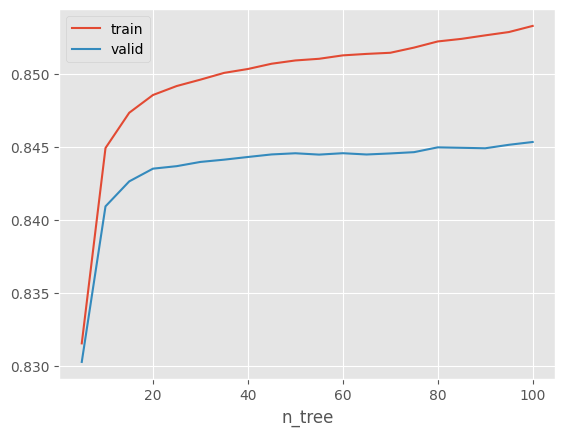

In [54]:
score_df.plot()
plt.legend(loc='best')

In [55]:
# # TODO: choose the best model from list
N = 10
# clf = RandomForestClassifier(N, **clf_parameters)
clf = LGBMClassifier(boosting_type='gbdt', **best_params)
# clf = LGBMClassifier(**grid_search.best_params_)
# clf = LGBMClassifier(best_params)
clf.fit(x_train, y_train)

LGBMClassifier(colsample_bytree=0.75, max_depth=8, min_child_samples=1000,
               num_leaves=80, subsample=0.6)

In [56]:
prob_array = np.array([-1, 1])
proba = clf.predict_proba(x_train.append(x_test))

# calculate alpha score
# method 1
# alpha_score = proba.dot(prob_array)
# method 2
alpha_score = proba[:, 1]

# check classifier classes (the respective column names of predict_proba)
clf.classes_

array([0, 1])

In [58]:
# factors = ['rsi', 'bollinger_ratio', 'cv_ratio', 'macd_signal', 'macd', 'ma_diff', 
#            'trailing_return_1y', 'trailing_return_1m']
factors = ['bollinger_ratio', 'macd_signal', 'macd', 
           'trailing_return_1y', 'trailing_return_1m', 
           'asti_12m_1m']
alpha_score_label = 'AI_ALPHA'
factor_list = factors + [alpha_score_label]
# factors_with_alpha = df.loc[x_train.index].copy()
factors_with_alpha = df.copy()
factors_with_alpha[alpha_score_label] = alpha_score
selected_factor_df = factors_with_alpha[factor_list]
selected_factor_df.tail(3)

,,bollinger_ratio,macd_signal,macd,trailing_return_1y,trailing_return_1m,asti_12m_1m,AI_ALPHA
date,ticker,,,,,,,
2024-11-26,YUASA,NaN,0.0,0.0,-0.079646,-0.045872,-0.033775,0.000432
2024-11-27,YUASA,NaN,0.0,0.0,-0.080357,-0.055046,-0.025311,0.000150
2024-11-28,YUASA,NaN,0.0,0.0,-0.080357,-0.072072,-0.008285,0.000151


In [59]:
alpha_eval = AlphaFactorEvaluator(factor_return=selected_factor_df, price=close_df_pivot)
factor_data_dict = alpha_eval.combine_factor_forward_returns(periods = (1, 5, 10), max_loss = 0.35, verbose = True)

Formatting factor data for bollinger_ratio
Dropped 3.1% entries from factor data: 3.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for macd_signal
Dropped 1.0% entries from factor data: 0.3% in forward returns computation and 0.6% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for macd
Dropped 1.0% entries from factor data: 0.3% in forward returns computation and 0.6% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for trailing_return_1y
Dropped 8.7% entries from factor data: 8.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for trailing_return_1m
Droppe

In [60]:
factor_return_df = alpha_eval.get_factor_returns(
    factor_data_dict,
    demeaned=False,
    group_adjust=False,
    equal_weight=False
)

Text(0.5, 1.0, 'compared with the AI generated')

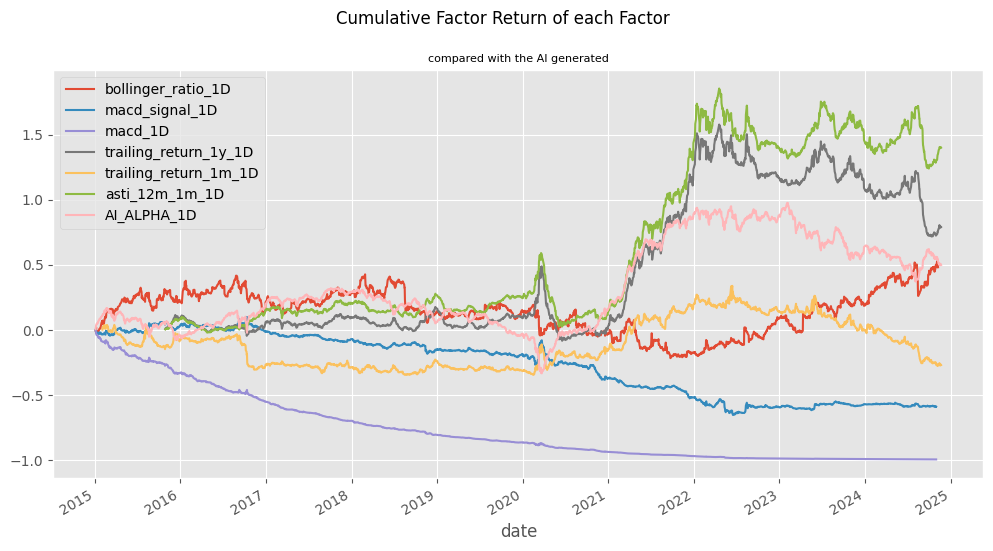

In [62]:
# # * period-wise return
# alpha = 0.6
# factor_return_df.plot(alpha = alpha)
# plt.legend()

# # * cumulative return
period = '1D'
period_col = [c for c in factor_return_df if period in c]

fig, ax = plt.subplots(figsize=(12, 6))
factor_return_df[period_col].add(1).cumprod().add(-1).plot(ax=ax)
plt.suptitle('Cumulative Factor Return of each Factor', size = 12)
plt.title('compared with the AI generated', size = 8)

In [51]:
# # factor_return_df['trailing_return_1y_5D'].sort_values(ascending=False).head()
# tmp_df = factor_data_dict['trailing_return_1y']
# # tmp_df.loc[dt.datetime(2021, 7, 1):dt.datetime(2021, 7, 31)]
# tmp_df[(tmp_df.index.get_level_values(0) >= (dt.datetime(2021, 7, 1))) &
#        (tmp_df.index.get_level_values(0) <= (dt.datetime(2021, 7, 31)))]
# tmp_df[tmp_df.index.get_level_values(0) == dt.datetime(2021, 7, 2)].sort_values(by='5D', ascending=False)

<AxesSubplot: xlabel='date'>

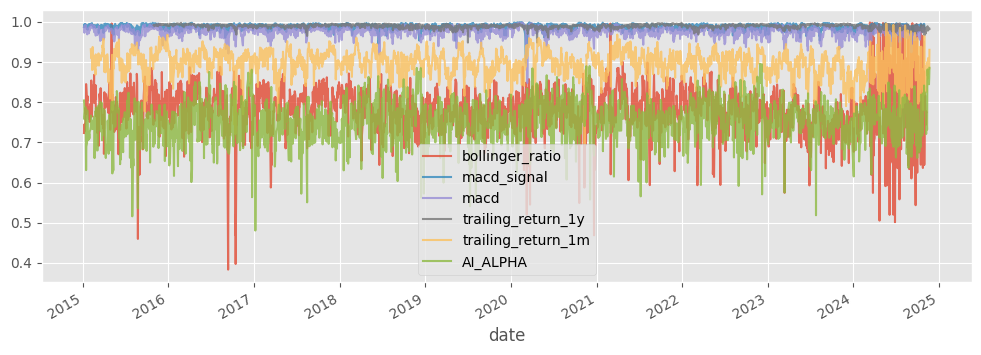

In [35]:
# Factor Rank Autocorrelation
rank_ac_df = alpha_eval.get_factor_rank_autocorrelation(factor_data_dict)
rank_ac_df.plot(alpha = 0.8, figsize = (12, 4))

(-1.0, 6.0)

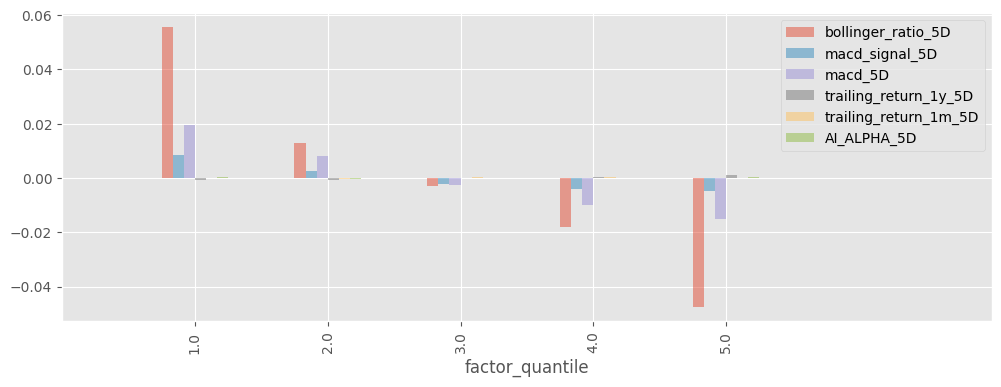

In [59]:
# mean return by quantile
qt_return_df = alpha_eval.get_mean_return_by_quantile(factor_data_dict)
period = '5D'
period_col = [c for c in factor_return_df if period in c]
qt_return_df[period_col].plot(kind='bar', alpha = 0.5, figsize=(12, 4))
plt.xlim([-1, 6])

In [60]:
# save factor_data
base_path = './test/alphalens/factor_data'
for factor_name, factor_df in factor_data_dict.items():
    factor_df.to_csv(f'{base_path}/factor_data_{factor_name}.csv')

# # load factor data
# factor_data_dict = dict()
# factor_list = []
# base_path = './test/alphalens/factor_data'
# for filename in os.listdir(base_path):
#     factor_name = filename.split('.')[0].replace('factor_data_', '')
#     factor_data_dict[factor_name] = pd.read_csv(f'{base_path}/{filename}', index_col=['date', 'asset'])
#     factor_list.append(factor_name)

In [61]:
# Get factor weight
factor_weight_list = []
for factor in factor_list:
    factor_weight = al.performance.factor_weights(
        factor_data=factor_data_dict[factor],
        demeaned=False,
        group_adjust=False,
        equal_weight=False
    ).to_frame()
    factor_weight.columns = [factor]
    factor_weight_list.append(factor_weight)

factor_weight_df = pd.concat(factor_weight_list, axis=1)
factor_weight_df.head(3)

,,bollinger_ratio,macd_signal,macd,trailing_return_1y,trailing_return_1m,AI_ALPHA
date,asset,,,,,,
2024-11-08,2S,0.002538,NaN,NaN,-0.000499,-0.000922,0.000915
2024-11-07,2S,0.002725,NaN,NaN,-0.000452,-0.001016,0.000991
2024-11-06,2S,0.002412,NaN,NaN,-0.000389,-0.001192,0.000111


In [62]:
factor_weight_df.groupby(factor_weight_df.index.get_level_values(0)).sum().head(3)

,bollinger_ratio,macd_signal,macd,trailing_return_1y,trailing_return_1m,AI_ALPHA
date,,,,,,
2021-02-03,0.980345,-0.706003,-0.666492,0.956472,0.403045,1.0
2021-02-04,0.974187,-0.709332,-0.659638,0.954196,0.458410,1.0
2021-02-05,0.990410,-0.714652,-0.640256,0.945688,0.338954,1.0


In [63]:
# Compute factor alpha and beta
res_list = []
for factor in selected_factor_df.columns:
    alpha_beta = al.performance.factor_alpha_beta(factor_data=factor_data_dict[factor])
    alpha_beta.columns = [f'{factor}_return_{c}' for c in alpha_beta.columns]
    res_list.append(alpha_beta)
alpha_beta_df = pd.concat(res_list, axis=1).T

In [64]:
alpha_beta_df

,Ann. alpha,beta
bollinger_ratio_return_1D,-0.973182,-0.036792
bollinger_ratio_return_5D,-0.896374,-0.146364
bollinger_ratio_return_10D,-0.808639,-0.177414
macd_signal_return_1D,-0.083257,0.007450
macd_signal_return_5D,-0.392234,-0.046548
macd_signal_return_10D,-0.627088,-0.179969
macd_return_1D,-0.395582,-0.018105
macd_return_5D,-0.698835,-0.175674
macd_return_10D,-0.789691,-0.333939
trailing_return_1y_return_1D,-0.004410,0.091162


In [65]:
# Quantile turnover
# quantile_turnover = al.performance.quantile_turnover(factor_data_dict['AI_ALPHA']['factor_quantile'], quantile=1, period=1)
# quantile_turnover.head(3)

quantile_turnover_dict = {}
for factor in factor_list:
    turnover_list = []
    for q in range(1, 6):
        quantile_turnover = al.performance.quantile_turnover(factor_data_dict[factor]['factor_quantile'], quantile=q, period=1) \
                                .to_frame()
        quantile_turnover.columns = [f'q{q}']
        turnover_list.append(quantile_turnover)
    turnover_df = pd.concat(turnover_list, axis=1) \
                    .dropna()
    quantile_turnover_dict[factor] = turnover_df

Text(0.5, 1.0, 'Quantile Turnover (rolling 5 period average) for factor: bollinger_ratio')

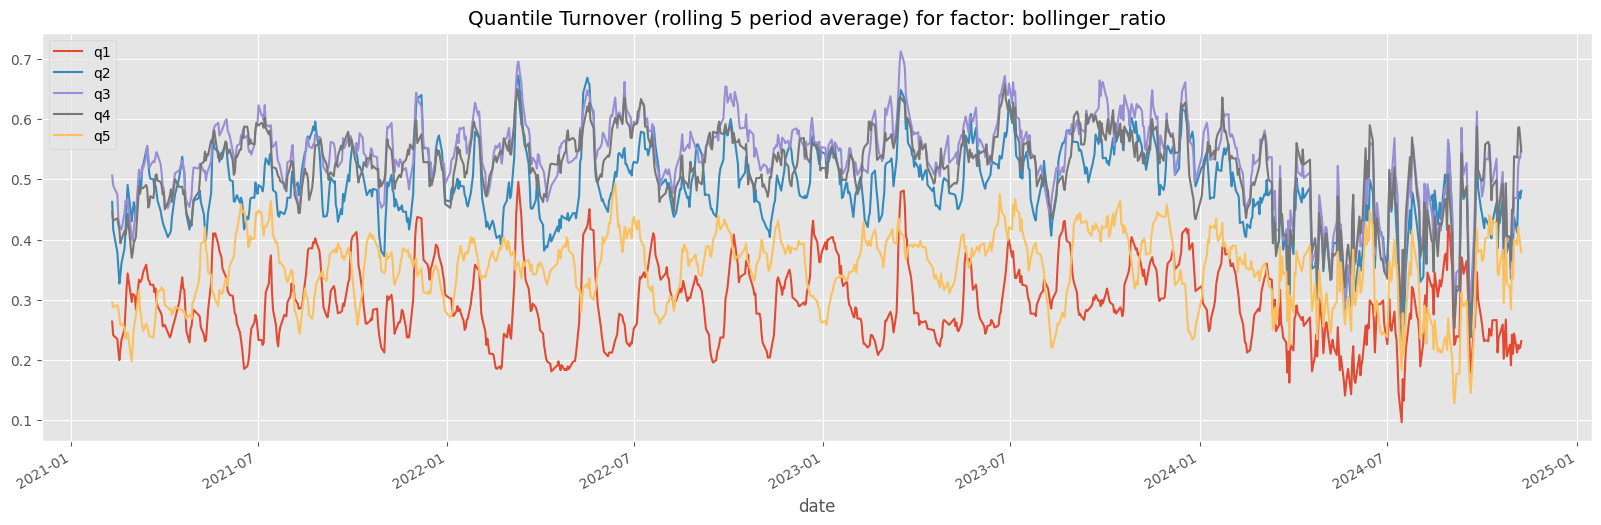

In [66]:
# visualize quantile turnover by factor
factor_name = 'bollinger_ratio'
n_rolling = 5
quantile_turnover_dict[factor_name].rolling(n_rolling).mean().plot(figsize=(20,6))
plt.title(f'Quantile Turnover (rolling {n_rolling} period average) for factor: {factor_name}')

<h1 style="color:turquoise">Filter factor by period-wise top rank</h1>
<p>Rationale is that we want to limit the number of invested assets in a given time period. Therefore, in a long-only portfolio, we will invest in only assets of which the factor values are in the top-tier</p>

In [67]:
TOP_N = 5
EQUAL_WEIGHT = False
rank_df = selected_factor_df.copy()
flag_cols = []
rank_cols = []
for c in rank_df.columns:
    rank_df[f'period_rank_{c}'] = rank_df.groupby(rank_df.index.get_level_values(0))[c].rank(method='min', ascending=False)

    # ? add new factor name to selected columns with flag that the asset is selected
    select_flag_name = f'is_selected_{c}_top_{TOP_N}'
    flag_cols.append(select_flag_name)
    rank_factor_name = f'{c}_top_{TOP_N}'
    rank_cols.append(rank_factor_name)
    rank_df[select_flag_name] = rank_df.apply(lambda row: 1 if row[f'period_rank_{c}'] <= TOP_N else 0, axis=1)
    if EQUAL_WEIGHT:
        rank_df[rank_factor_name] = rank_df.apply(lambda row: 1 / TOP_N if row[f'period_rank_{c}'] <= TOP_N else 0, axis=1)
    else:
        rank_df[rank_factor_name] = rank_df.apply(lambda row: row[c] if row[f'period_rank_{c}'] <= TOP_N else 0, axis=1)
rank_df = rank_df[flag_cols + rank_cols]

In [68]:
rank_df.head(3)

,,is_selected_bollinger_ratio_top_5,is_selected_macd_signal_top_5,is_selected_macd_top_5,is_selected_trailing_return_1y_top_5,is_selected_trailing_return_1m_top_5,is_selected_AI_ALPHA_top_5,bollinger_ratio_top_5,macd_signal_top_5,macd_top_5,trailing_return_1y_top_5,trailing_return_1m_top_5,AI_ALPHA_top_5
date,asset,,,,,,,,,,,,
2024-11-28,2S,0,1,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2024-11-27,2S,0,1,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2024-11-26,2S,0,1,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
top_n_dict = {}
for flag, factor in zip(flag_cols, rank_cols):
    factor_series = rank_df[factor]
    selected_flag = rank_df[flag]
    forward_return = al.utils.compute_forward_returns(factor_series, close_df_pivot, periods=(1, 5, 10))
    forward_return['factor'] = factor_series
    forward_return['quantile'] = selected_flag
    top_n_dict[factor] = forward_return

In [70]:
top_n_return_list = []
for factor, factor_df in top_n_dict.items():
    top_n_return = al.performance.factor_returns(top_n_dict[factor], demeaned=False, group_adjust=False, equal_weight=True, by_asset=False)
    top_n_return.columns = [f'{factor}_{c}' for c in top_n_return.columns]
    top_n_return_list.append(top_n_return)
top_n_return_df = pd.concat(top_n_return_list, axis=1)

In [72]:
top_n_return_df.tail()

,bollinger_ratio_top_5_1D,bollinger_ratio_top_5_5D,bollinger_ratio_top_5_10D,macd_signal_top_5_1D,macd_signal_top_5_5D,macd_signal_top_5_10D,macd_top_5_1D,macd_top_5_5D,macd_top_5_10D,trailing_return_1y_top_5_1D,trailing_return_1y_top_5_5D,trailing_return_1y_top_5_10D,trailing_return_1m_top_5_1D,trailing_return_1m_top_5_5D,trailing_return_1m_top_5_10D,AI_ALPHA_top_5_1D,AI_ALPHA_top_5_5D,AI_ALPHA_top_5_10D
date,,,,,,,,,,,,,,,,,,
2024-11-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007977,-0.026791,0.0,-0.001056,-0.076519,0.0,-0.000439,-0.000958,0.0
2024-11-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.007454,0.018464,0.0,-0.033137,-0.012444,0.0,-0.027006,-0.016238,0.0
2024-11-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016115,0.026669,0.0,-0.060369,-0.046884,0.0,-0.003030,-0.002533,0.0
2024-11-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007583,0.027399,0.0,-0.021873,-0.024257,0.0,0.038171,0.023805,0.0
2024-11-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.014708,-0.002433,0.0,0.011167,0.001469,0.0,0.011037,0.033140,0.0


Text(0.5, 1.0, 'compared with the AI generated')

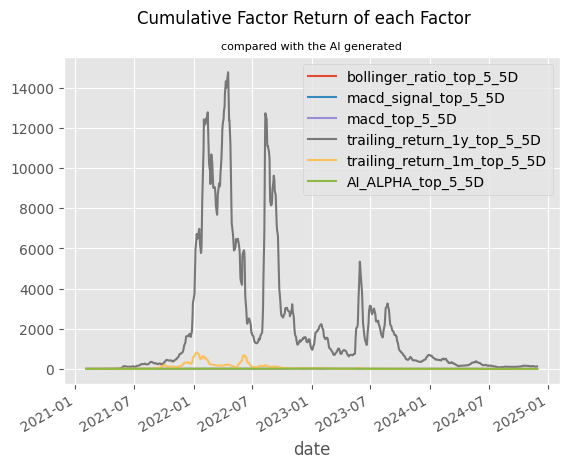

In [73]:
# # * cumulative return
period = '5D'
period_col = [c for c in top_n_return_df if period in c]
top_n_return_df[period_col].add(1).cumprod().add(-1).plot()
plt.suptitle('Cumulative Factor Return of each Factor', size = 12)
plt.title('compared with the AI generated', size = 8)

<h1 style="color:turquoise">Predict future return and select Top N</h1>

In [74]:
predict_df.tail(2)

,,RSI,stoch_rsi_k,stoch_rsi_d,macd,macd_signal,volume_change_pct,overnight_return,candlestick_volume_ratio,bollinger_ratio,trailing_return_1m,...,sector_PROPCON,sector_PROPCON-m,sector_RESOURC,sector_RESOURC-m,sector_SERVICE,sector_SERVICE-m,sector_TECH,sector_TECH-m,month,day_of_week
date,ticker,,,,,,,,,,,,,,,,,,,,,
2014-01-03,YUASA,60.0,0.861539,0.722508,0.015982,0.003817,-0.702593,0.000000,0.000000e+00,0.815199,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,4
2014-01-02,YUASA,60.0,0.861539,0.861539,0.017990,0.006652,1.790935,0.007194,4.562061e-07,0.784008,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3


In [75]:
forward_pred = clf.predict_proba(predict_df.drop(return_col_name, axis=1))
forward_pred_df = pd.DataFrame(forward_pred[:, 1], index=predict_df.index, columns=['score'])

In [76]:
forward_pred_df['score'].nunique()

827205

In [77]:
forward_pred_df['period_rank'] = forward_pred_df.groupby(forward_pred_df.index.get_level_values(0))['score'] \
                                    .rank(method='min', ascending=False)
forward_pred_df['top_score'] = forward_pred_df.apply(lambda row: row['score'] if row[f'period_rank'] <= TOP_N else 0, axis=1)
top_df = forward_pred_df[forward_pred_df['top_score'] > 0.0].reset_index() \
            .sort_values(by=['date', 'period_rank']).set_index('date')
top_df.loc[top_df.index.max()].head(10)

,ticker,score,period_rank,top_score
date,,,,
2024-12-06,EFORL,0.000845,1.0,0.000845
2024-12-06,CCET,0.000831,2.0,0.000831
2024-12-06,INET,0.000831,2.0,0.000831
2024-12-06,MONO,0.000831,2.0,0.000831
2024-12-06,SIS,0.000773,5.0,0.000773


<h2>Compare to the best factor</h2>

In [79]:
TOP_N = 10
factor_name = 'trailing_return_1y'
select_factor_df = predict_df[[factor_name]]
select_factor_df['period_rank'] = select_factor_df.groupby(select_factor_df.index.get_level_values(0))[factor_name] \
                                    .rank(method='min', ascending=False)
select_factor_df['top_score'] = select_factor_df.apply(lambda row: row[factor_name] if row[f'period_rank'] <= TOP_N else 0, axis=1)
factor_top_df = select_factor_df[select_factor_df['top_score'] > 0.0].reset_index() \
                    .sort_values(by=['date', 'period_rank']).set_index('date')
factor_top_df.loc[factor_top_df.index.max()].head(10)

,ticker,trailing_return_1y,period_rank,top_score
date,,,,
2024-12-06,MONO,1.906977,1.0,1.906977
2024-12-06,CCET,1.875817,2.0,1.875817
2024-12-06,SAMTEL,1.333333,3.0,1.333333
2024-12-06,MCOT,1.236842,4.0,1.236842
2024-12-06,TRUE,0.875969,5.0,0.875969
2024-12-06,DELTA,0.869969,6.0,0.869969
2024-12-06,SSC,0.838235,7.0,0.838235
2024-12-06,HTECH,0.741667,8.0,0.741667
2024-12-06,KGEN,0.727273,9.0,0.727273


<h1 style="color:turquoise">Use No Overlap Voter to generate an AI-based Alpha Factor</h1>

In [34]:
n_stocks = len(sector_mapper_available)
n_days = len(x_train)

clf_parameters = {
    'criterion': 'entropy',
    'min_samples_leaf': 100,
    'min_samples_split': 100,
    'max_depth': 4,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 42}
n_trees_l = range(5, 55, 5)

scores = []
feature_importances = []

for n_trees in n_trees_l:
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf_nov = NoOverlapClassifier(estimator = clf)
    clf_nov.fit(x_train, y_train)
    scores.append({
        'n_tree': n_trees,
        'train': clf_nov.score(x_train, y_train.values),
        'valid': clf_nov.score(x_test, y_test.values),
        'oob': clf_nov.oob_score_
    })

score_df = pd.DataFrame.from_dict(scores) \
            .set_index('n_tree')

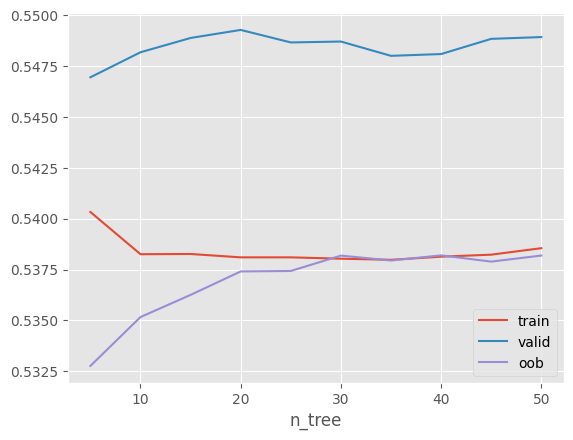

In [35]:
score_df.plot()
plt.legend(loc='best')

In [36]:
# # TODO: choose the best model
N_TREE = 40
clf_best = RandomForestClassifier(N_TREE, **clf_parameters)
clf_nov_best = NoOverlapClassifier(estimator=clf_best)
clf_nov_best.fit(x_train, y_train)

NoOverlapClassifier(estimator=RandomForestClassifier(criterion='entropy',
                                                     max_depth=4,
                                                     min_samples_leaf=100,
                                                     min_samples_split=100,
                                                     n_estimators=40, n_jobs=-1,
                                                     oob_score=True,
                                                     random_state=42))

In [37]:
prob_array = np.array([-1, 1])
proba = clf_nov.predict_proba(x_train)
alpha_score = proba.dot(prob_array)

In [38]:
factors = ['rsi', 'bollinger_ratio', 'cv_ratio', 'macd_signal', 'macd']
alpha_score_label = 'AI_ALPHA'
factors_with_alpha = df.loc[x_train.index].copy()
factors_with_alpha[alpha_score_label] = alpha_score
selected_factor_df = factors_with_alpha[factors + [alpha_score_label]]
selected_factor_df.head(3)

,,rsi,bollinger_ratio,cv_ratio,macd_signal,macd,AI_ALPHA
date,ticker,,,,,,
2015-01-05,AEONTS,35.714400,0.110593,0.000007,0.584415,-0.060833,-0.020885
2015-01-06,AEONTS,33.333357,0.166329,0.000014,0.431636,-0.179480,-0.037210
2015-01-07,AEONTS,25.000020,0.224731,0.000014,0.297455,-0.239269,-0.031938


In [39]:
alpha_eval = AlphaFactorEvaluator(factor_return=selected_factor_df, price=close_df_pivot)
factor_data_dict = alpha_eval.combine_factor_forward_returns(period = 1, max_loss = 0.4, verbose = True)

Formatting factor data for rsi
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 40.0%, not exceeded: OK!
Formatting factor data for bollinger_ratio
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 40.0%, not exceeded: OK!
Formatting factor data for cv_ratio
Dropped 0.5% entries from factor data: 0.0% in forward returns computation and 0.5% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 40.0%, not exceeded: OK!
Formatting factor data for macd_signal
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 40.0%, not exceeded: OK!
Formatting factor data for macd
Dropped 0.0% entries from facto

In [40]:
# factor_data_dict.keys()
# save results
for factor, value_df in factor_data_dict.items():
    value_df.to_csv(f'./test/alphalens/factor_exposure_{factor}.csv')

In [38]:
factor_return_df = alpha_eval.get_factor_returns(factor_data_dict)

In [ ]:
# # save result
# factor_return_df.to_csv('./test/alphalens/factor_return_df.csv')

Text(0.5, 1.0, 'compared with the AI generated')

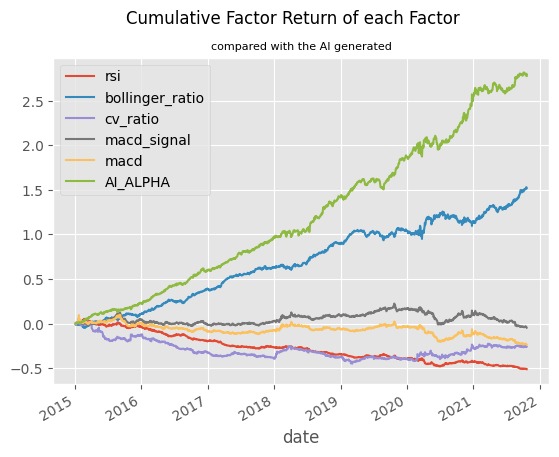

In [ ]:
factor_return_df.add(1).cumprod().add(-1).plot()
plt.suptitle('Cumulative Factor Return of each Factor', size = 12)
plt.title('compared with the AI generated', size = 8)

In [ ]:
# mean return by quantile
qt_return_df = alpha_eval.get_mean_return_by_quantile(factor_data_dict)

In [ ]:
# qt_return_df.to_csv('./test/alphalens/mean_return_by_quantile.csv')

<AxesSubplot: xlabel='factor_quantile'>

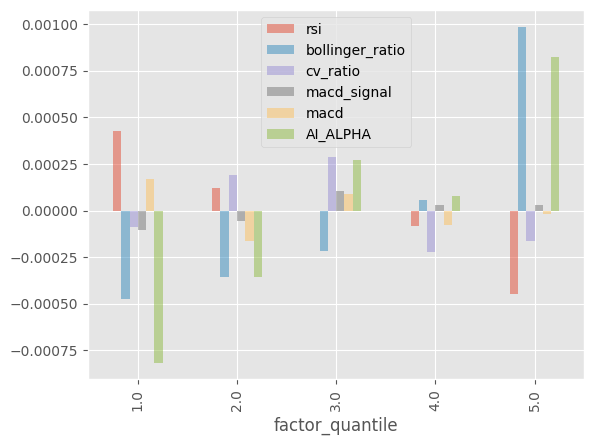

In [ ]:
qt_return_df.plot(kind = 'bar', alpha = 0.5)